In [1]:
# Importing necessary libraries

import random
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)


# Defining the FinancialPortfolio class
class FinancialPortfolio:
    def __init__(self, portfolio):
        """
        Initialize the FinancialPortfolio with a given portfolio.
        :param portfolio: A dictionary representing the financial portfolio.
        """
        self.portfolio = portfolio

    def calculate_aggregated_future_value(self, years):
        """
        Calculate the aggregated future value of all strategies in the portfolio over a number of years.
        :param years: Number of years to calculate the future value for.
        :return: Final portfolio value and total tax paid.
        """
        total_portfolio_value = 0
        total_tax_paid = 0
        for strategy in self.portfolio['strategies']:
            value, tax_paid = self.calculate_future_value(strategy, years)
            total_portfolio_value += value[-1]  # Sum the final values of each strategy
            total_tax_paid += tax_paid
        return total_portfolio_value, total_tax_paid

    def calculate_future_value(self, strategy, years):
        """
        Calculate the future value of an investment strategy over a number of years.
        :param strategy: A dictionary containing strategy details.
        :param years: Number of years to calculate the future value for.
        :return: A tuple containing an array of future values and total tax paid.
        """
        principal = strategy['initial_funds']
        monthly_contribution = strategy['monthly_contribution']
        annual_rate = strategy['annual_rate']
        variance = strategy['variance']
        is_taxable = strategy.get('is_taxable', False)
        tax_rate = strategy.get('tax_rate', 10)
        compounding_frequency = strategy.get('compounding_frequency', 1)

        months = years * 12
        future_values = []
        annual_tax_paid = []
        principal_start_of_year = principal

        for month in range(1, months + 1):
            varied_rate = annual_rate * (1 + random.uniform(-variance, variance) / 100)
            rate_per_month = varied_rate / 12 / 100

            if month % 12 == 1:
                principal_start_of_year = principal

            if month % compounding_frequency == 0:
                principal = principal * (1 + rate_per_month * compounding_frequency)
            principal += monthly_contribution

            if month % 12 == 0 and is_taxable:
                annual_profit = principal - principal_start_of_year - (monthly_contribution * 12)
                tax = annual_profit * tax_rate / 100 if annual_profit > 0 else 0
                principal -= tax
                annual_tax_paid.append(tax)

            future_values.append(principal)

        total_tax_paid = sum(annual_tax_paid)
        return np.array(future_values), total_tax_paid

    def plot_strategy(self, strategy, years, ax):
        """
        Plot an individual investment strategy.
        :param strategy: A dictionary containing strategy details.
        :param years: Number of years for the strategy.
        :param ax: Matplotlib Axes object for plotting.
        """
        value, tax_paid = self.calculate_future_value(strategy, years)

        final_value = value[-1]
        total_contributions = strategy['initial_funds'] + strategy['monthly_contribution'] * 12 * years
        gross_profit = final_value - total_contributions
        net_profit = gross_profit - tax_paid

        ax.plot(np.arange(1, years * 12 + 1), value,
                label=f"{strategy['name']} (Final: ${final_value:,.2f}, Net: ${net_profit:,.2f}, Tax: ${tax_paid:,.2f})")
        ax.axhline(y=total_contributions, color='gray', linestyle='--',
                   label=f"{strategy['name']} Contributions: ${total_contributions:,.2f}")

    def plot_combined_portfolio(self, years, ax):
        """
        Plot the combined value of all strategies in the portfolio.
        :param years: Number of years for the portfolio.
        :param ax: Matplotlib Axes object for plotting.
        """
        total_portfolio_value = np.zeros(years * 12)
        total_contributions = 0
        total_tax_paid = 0

        for strategy in self.portfolio['strategies']:
            value, tax_paid = self.calculate_future_value(strategy, years)

            total_portfolio_value += value
            total_contributions += strategy['initial_funds'] + strategy['monthly_contribution'] * 12 * years
            total_tax_paid += tax_paid

        final_total_value = total_portfolio_value[-1]
        gross_profit = final_total_value - total_contributions
        net_profit = gross_profit - total_tax_paid

        ax.plot(np.arange(1, years * 12 + 1), total_portfolio_value,
                label=f"Total Portfolio (Final: ${final_total_value:,.2f}, Net: ${net_profit:,.2f}, Tax: ${total_tax_paid:,.2f})")
        ax.axhline(y=total_contributions, color='gray', linestyle='--',
                   label=f"Total Contributions: ${total_contributions:,.2f}")
        ax.set_xlabel('Months')
        ax.set_ylabel('Portfolio Value')
        ax.set_title(f"Combined Portfolio: {self.portfolio['name']} Growth Over {years} Years")
        ax.legend()
        ax.grid(True)


# Function to plot the portfolios using the FinancialPortfolio class
def plot_portfolios(portfolios, years, use_default_size=True):
    """
    Plot the provided portfolios.
    :param portfolios: A list of portfolio dictionaries.
    :param years: Number of years to plot.
    :param use_default_size: Boolean to choose the default size of the plot.
    """
    num_portfolios = len(portfolios)

    # Determine the size of the plot based on the number of portfolios
    if use_default_size:
        fig_size = (10, 8)
    else:
        fig_size = (15 * num_portfolios, 16)

    # Create subplot axes
    fig, axes = plt.subplots(2, num_portfolios, figsize=fig_size)

    # Ensure axes is iterable when there is only one portfolio
    if num_portfolios == 1:
        axes = np.array([axes]).T

    for i, portfolio in enumerate(portfolios):
        financial_portfolio = FinancialPortfolio(portfolio)

        # Plot each strategy in the portfolio
        for strategy in portfolio['strategies']:
            financial_portfolio.plot_strategy(strategy, years, axes[0, i])
        axes[0, i].set_title(f"Strategies in {portfolio['name']}")
        axes[0, i].legend()
        axes[0, i].grid(True)

        # Plot the combined portfolio
        financial_portfolio.plot_combined_portfolio(years, axes[1, i])

    plt.tight_layout()
    plt.show()



def display_initial_funds_and_contributions_table(portfolios):
    """
    Display a table summarizing the initial funds and monthly contributions for each portfolio.
    :param portfolios: A list of portfolio dictionaries.
    """
    plt.figure(figsize=(10, 2))

    # Create a table to display initial funds and monthly contributions
    table_data = [["Portfolio", "Initial Funds ($)", "Monthly Contributions ($)"]]
    for portfolio in portfolios:
        portfolio_name = portfolio['name']
        initial_funds_total = sum(s['initial_funds'] for s in portfolio['strategies'])
        monthly_contributions_total = sum(s['monthly_contribution'] * 12 for s in portfolio['strategies'])
        table_data.append([portfolio_name, f"{initial_funds_total:,.2f}", f"{monthly_contributions_total:,.2f}"])

    # Creating the table with matplotlib
    table = plt.table(cellText=table_data, loc='center', cellLoc='center',
                      cellColours=[['lightgray'] * 3] * (len(portfolios) + 1))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    plt.axis('off')
    plt.title('Total Initial Funds and Total Monthly Contributions by Portfolio')
    plt.show()





def plot_portfolios_over_time(portfolios, timeframes, use_default_size=True):
    # Set the plot size
    if use_default_size:
        plt.figure(figsize=(15, 10))
    else:
        plt.figure(figsize=(20, 15))  # Adjust figure size

    num_portfolios = len(portfolios)
    total_width = 0.8  # Total width for all bars at a single point
    individual_width = total_width / len(timeframes)  # Width of each individual bar

    # Variable to keep track of the highest value for y-axis limit adjustment
    highest_final_value = 0

    # Create legend labels for each set of portfolios
    legend_labels = []

    for j, years in enumerate(timeframes):
        # Create the legend label for this timeframe
        legend_label = f"{years} years"
        legend_labels.append(legend_label)

        for i, portfolio_dict in enumerate(portfolios):
            portfolio = FinancialPortfolio(portfolio_dict)
            final_value, total_tax_paid = portfolio.calculate_aggregated_future_value(years)
            net_profit = final_value - total_tax_paid

            # Update highest_final_value if this final_value is greater
            highest_final_value = max(highest_final_value, final_value)

            # Position of the bar
            position = i - total_width / 2 + individual_width / 2 + j * individual_width

            # Plotting the bar
            plt.bar(position, final_value, width=individual_width, label=f"{portfolio.portfolio['name']} - {years} years" if j == 0 else "")

            # Adding annotations
            plt.annotate(f"Final: ${final_value:,.2f}\nNet: ${net_profit:,.2f}\nTax: ${total_tax_paid:,.2f}",
                         xy=(position, final_value),
                         xytext=(0, 3),  # 3 points vertical offset
                         textcoords="offset points",
                         ha='center', va='bottom')

    plt.xlabel('Portfolios')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Comparison Over Different Timeframes')
    plt.xticks(range(num_portfolios), [p['name'] for p in portfolios])

    # Adjust the layout, legend, and y-limit for better readability
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.85)
    plt.legend(legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.07),
               fancybox=True, shadow=True, ncol=len(timeframes))

    # Adjust the y-axis limit to add padding above the highest bar
    top_padding = highest_final_value * 0.1  # 10% padding above the highest bar
    plt.ylim(bottom=0, top=highest_final_value + top_padding)

    # Show the plot with the adjustments
    plt.show()



def display_final_values_table(portfolios, timeframes):
    """
    Display a table summarizing the final values, net profits, and taxes paid for each portfolio over different timeframes.
    :param portfolios: A list of portfolio dictionaries.
    :param timeframes: A list of timeframes to calculate the values for.
    """
    # Header row for the table
    header_row = ['Portfolio']
    for years in timeframes:
        header_row.extend([f"Final Value {years}yr", f"Net {years}yr", f"Tax {years}yr"])

    table_data = [header_row]

    # Gather data for each portfolio and timeframe
    for portfolio_dict in portfolios:
        portfolio = FinancialPortfolio(portfolio_dict)
        row = [portfolio.portfolio['name']]
        for years in timeframes:
            final_value, tax_paid = portfolio.calculate_aggregated_future_value(years)
            net_profit = final_value - tax_paid
            row.extend([f"${final_value:,.2f}", f"${net_profit:,.2f}", f"${tax_paid:,.2f}"])
        table_data.append(row)

    # Determine the table figure size based on the number of columns
    fig_width = max(10, 1 * len(header_row))
    plt.figure(figsize=(fig_width, 2 + len(portfolios) * 0.3))

    # Create the table with matplotlib
    table = plt.table(cellText=table_data, loc='upper center', cellLoc='center', colWidths=[0.1] * len(header_row))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)

    plt.axis('off')
    plt.title('Portfolio Summary Over Different Timeframes')
    plt.tight_layout()
    plt.show()





In [2]:
example_portfolios = [
    {
        "name": "Portfolio 1 House",
        "strategies": [
            {"name": "Strategy A", "initial_funds": 0, "monthly_contribution": 800, "annual_rate": 6, "variance": 1, "is_taxable": True, "tax_rate": 10, "compounding_frequency": 6},
            {"name": "Strategy B", "initial_funds": 0, "monthly_contribution": 200, "annual_rate": 8, "variance": 1.5, "is_taxable": True, "tax_rate": 10, "compounding_frequency": 6}
        ]
    }
    # Additional portfolios can be added here
]


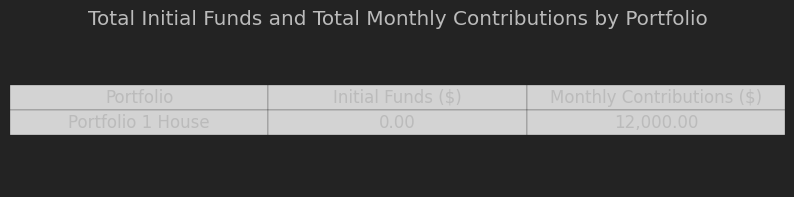

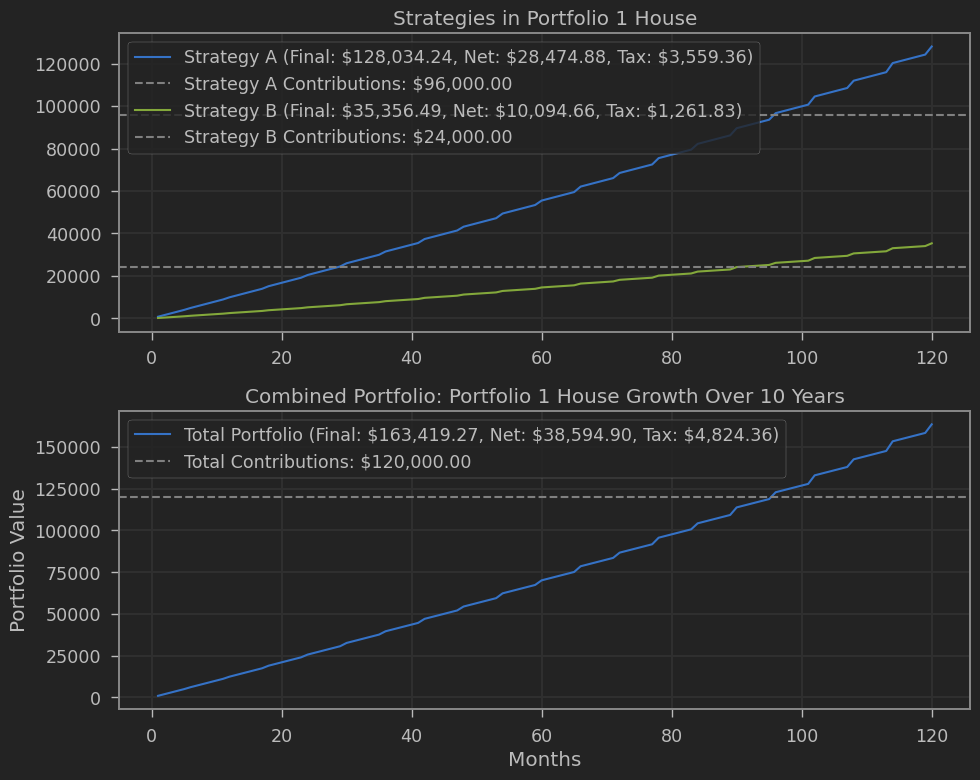

In [3]:
display_initial_funds_and_contributions_table(example_portfolios)

# Calling the function to plot the example portfolios
plot_portfolios(example_portfolios, 10, use_default_size=True)

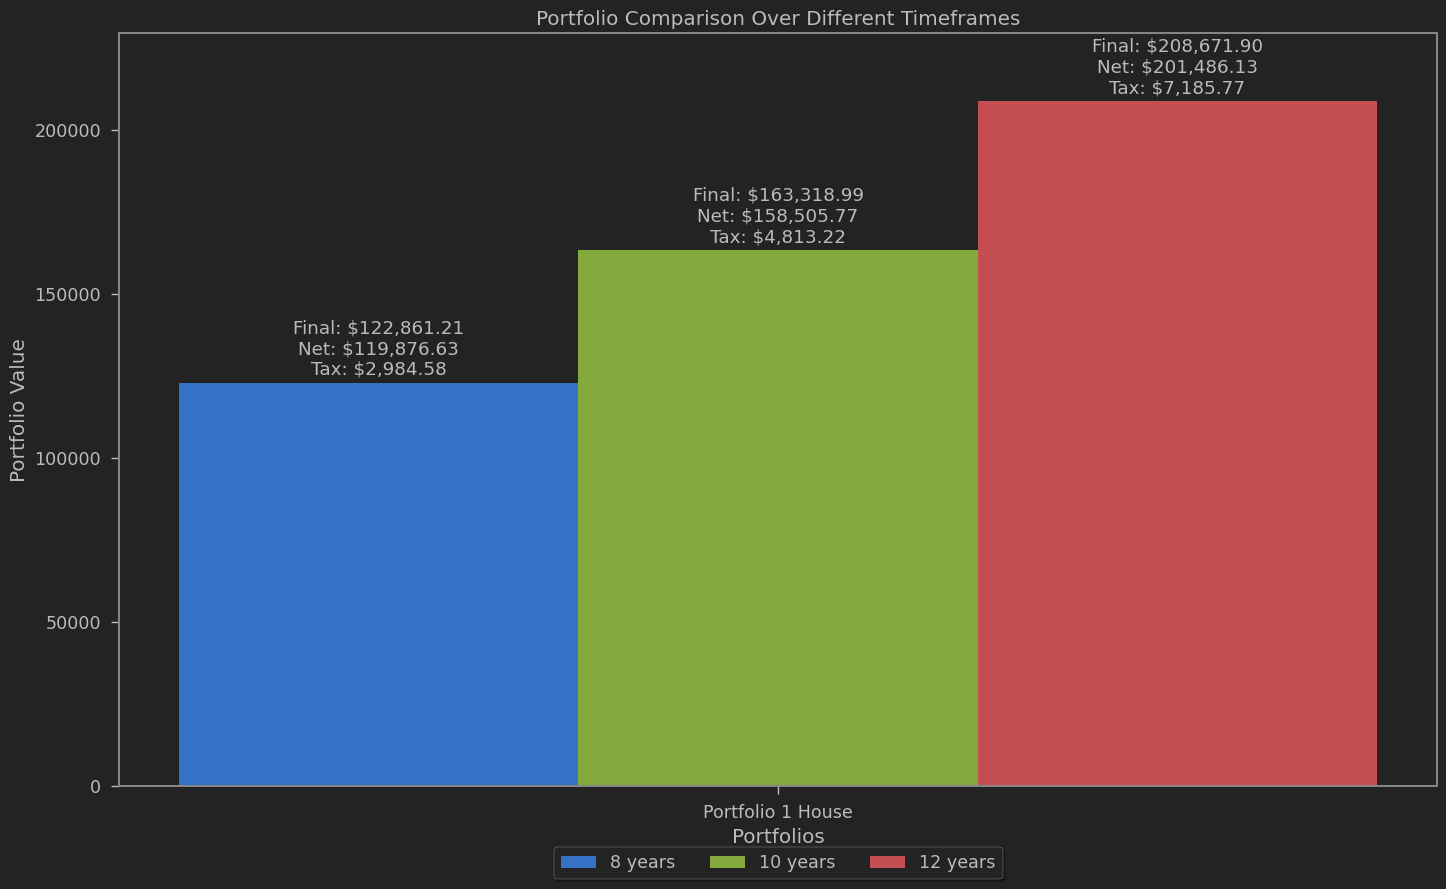

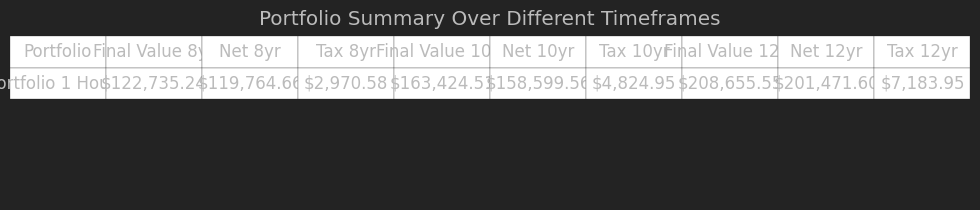

In [4]:
plot_portfolios_over_time(example_portfolios, [8, 10, 12], use_default_size=True)
display_final_values_table(example_portfolios, [8, 10, 12])

